<a href="https://colab.research.google.com/github/jacksonmcl/Federal_Funds_Rate_Model/blob/main/4.%20Multi-Variate%20Model%20Training/4.%20multivariate_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Github Setup

In [22]:
! apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [23]:
!git -C "Federal_Funds_Rate_Model" pull || git clone https://github.com/jacksonmcl/Federal_Funds_Rate_Model.git "Federal_Funds_Rate_Model"

Already up to date.


#Imports & Data

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms


from datetime import datetime
from functools import reduce
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

dfs = {}
feature_list = ['Lagged_FFER', 'Personal_Consumption_Expenditure', 'Mortgage_Rate']

In [25]:
dfs['Federal_Funds_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Federal_Funds_Rate.csv')
dfs['Lagged_FFER'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Lagged_FFR.csv')

dfs['Discount_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Discount_Rate.csv')
dfs['Prime_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Prime_Loan_Rate.csv')

dfs['Consumer_Price_Index'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Consumer_Price_Index.csv')
dfs['Producer_Price_Index'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Producer_Price_Index.csv')
dfs['Personal_Consumption_Expenditure'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Personal_Consumption_Expenditures.csv')

dfs['Unemployment_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Unemployment_Rate.csv')
dfs['Mortgage_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Mortgage_Rate.csv')
dfs['Auto_Loan_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Auto_Loan_Rate.csv')

ffr_df = dfs.pop('Federal_Funds_Rate')

# Mutli-Variate LSTM Model

In [26]:
dfs['Lagged_FFER'].drop(columns = ['ChangePercentYear', 'Value'], axis=1, inplace=True)
dfs['Personal_Consumption_Expenditure'].drop(columns = ['ChangePercentYear', 'Value'], axis=1, inplace=True)
dfs['Mortgage_Rate'].drop(columns = ['ChangePercentYear', 'Value'], axis=1, inplace=True)


ffr_df.drop(columns = ['ChangePercentYear', 'Value'], axis=1, inplace=True)

In [27]:
dfs['Lagged_FFER'].columns = ['Date', 'Lagged_FFER']
dfs['Lagged_FFER'].dropna(inplace=True)

dfs['Personal_Consumption_Expenditure'].columns = ['Date', 'Personal_Consumption_Expenditure']
dfs['Personal_Consumption_Expenditure'].dropna(inplace=True)

dfs['Mortgage_Rate'].columns = ['Date', 'Mortgage_Rate']
dfs['Mortgage_Rate'].dropna(inplace=True)

ffr_df.columns = ['Date', 'Federal_Funds_Rate']
ffr_df.dropna(inplace=True)

dataframe_list = [ffr_df] + [dfs[feature] for feature in feature_list]

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='inner'), dataframe_list)
df_merged.set_index('Date', inplace = True)

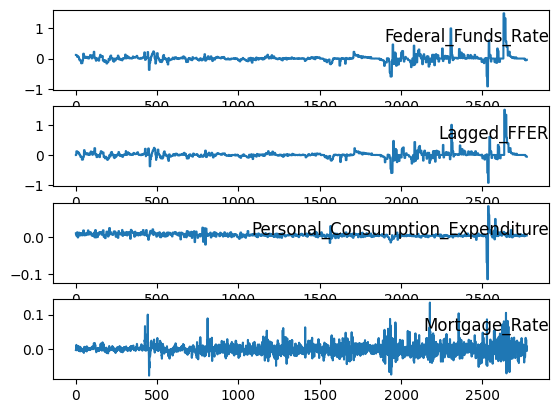

In [28]:
values = df_merged.values

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df_merged.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [29]:
df_merged

,Federal_Funds_Rate,Lagged_FFER,Personal_Consumption_Expenditure,Mortgage_Rate
Date,,,,
1971-04,0.121294,-0.002688,0.009971,-0.002729
1971-04,0.121294,-0.002688,0.009971,0.000000
1971-04,0.121294,-0.002688,0.009971,-0.002736
1971-05,0.112981,0.121294,0.003339,0.012346
1971-05,0.112981,0.121294,0.003339,0.005420
...,...,...,...,...
2024-10,-0.058480,-0.037523,0.003497,0.027523
2024-11,-0.039337,-0.058480,0.004042,0.010417
2024-11,-0.039337,-0.058480,0.004042,-0.001473


In [30]:
df_merged.index = pd.to_datetime(df_merged.index)
df_merged = df_merged.groupby(df_merged.index.date).mean()
df_merged

,Federal_Funds_Rate,Lagged_FFER,Personal_Consumption_Expenditure,Mortgage_Rate
1971-04-01,0.121294,-0.002688,0.009971,-0.001822
1971-05-01,0.112981,0.121294,0.003339,0.005787
1971-06-01,0.060475,0.112981,0.012589,0.002676
1971-07-01,0.081466,0.060475,-0.001286,0.004941
1971-08-01,0.048964,0.081466,0.008585,0.000014
...,...,...,...,...
2024-07-01,0.000000,0.000000,0.006016,-0.002863
2024-08-01,0.000000,0.000000,0.001948,-0.012913
2024-09-01,-0.037523,0.000000,0.006988,-0.010752
2024-10-01,-0.058480,-0.037523,0.003497,0.020259


In [36]:
# Save last 10 years for testing
test_len = 120
df_train = df_merged.iloc[:(644-test_len)]
df_test = df_merged.iloc[(644-test_len):]

In [37]:
x_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

x_train = x_scaler.fit_transform(df_train[feature_list])
y_train = y_scaler.fit_transform(df_train[['Federal_Funds_Rate']])

x_test = x_scaler.transform(df_test[feature_list])
y_test = y_scaler.transform(df_test[['Federal_Funds_Rate']])

In [38]:
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


(524, 1, 3) (524, 1) (120, 1, 3) (120, 1)


In [ ]:
# design network with 300 neurons
model = Sequential()
model.add(LSTM(100, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(x_train, y_train, epochs=30, batch_size=1, validation_data=(x_test, y_test), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


524/524 - 4s - 7ms/step - loss: 0.0276 - val_loss: 0.1779
Epoch 2/30
524/524 - 2s - 4ms/step - loss: 0.0261 - val_loss: 0.1747
Epoch 3/30
524/524 - 3s - 5ms/step - loss: 0.0259 - val_loss: 0.1744
Epoch 4/30
524/524 - 4s - 7ms/step - loss: 0.0258 - val_loss: 0.1749
Epoch 5/30
524/524 - 4s - 7ms/step - loss: 0.0257 - val_loss: 0.1759
Epoch 6/30
524/524 - 3s - 5ms/step - loss: 0.0255 - val_loss: 0.1774
Epoch 7/30
524/524 - 2s - 5ms/step - loss: 0.0254 - val_loss: 0.1795
Epoch 8/30
524/524 - 3s - 7ms/step - loss: 0.0253 - val_loss: 0.1817
Epoch 9/30
524/524 - 2s - 4ms/step - loss: 0.0252 - val_loss: 0.1842
Epoch 10/30
524/524 - 2s - 3ms/step - loss: 0.0251 - val_loss: 0.1870
Epoch 11/30
524/524 - 3s - 5ms/step - loss: 0.0250 - val_loss: 0.1900
Epoch 12/30
524/524 - 2s - 4ms/step - loss: 0.0250 - val_loss: 0.1932
Epoch 13/30
524/524 - 2s - 4ms/step - loss: 0.0249 - val_loss: 0.1964
Epoch 14/30
524/524 - 2s - 4ms/step - loss: 0.0248 - val_loss: 0.1997
Epoch 15/30
524/524 - 3s - 5ms/step - lo

In [ ]:
# make a prediction
yhat = model.predict(x_test)
# invert scaling for our forcast
inv_yhat = y_scaler.inverse_transform(yhat)
# Add our forecast to the test dataframe and plot the results
df_test['Predicted Federal_Funds_Rate'] = inv_yhat
df_test[['Federal_Funds_Rate','Predicted Federal_Funds_Rate']].plot(figsize=(14,5))
# Calculate RMSE
multi_rmse=sqrt(mean_squared_error(df_test['Federal_Funds_Rate'],df_test['Predicted Federal_Funds_Rate']))
print('Test RMSE:' , multi_rmse)